In [1]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
from matplotlib.pyplot import imshow
import requests
import random
import os
import base64
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Model
from hashlib import md5
import pickle
try:
    from urllib import unquote
except ImportError:
    from urllib.parse import unquote
from PIL import Image
import requests
try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO
from IPython.display import HTML, Image as iPythonImage, display
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image

In [2]:
query = """SELECT DISTINCT ?pic
WHERE
{
    ?item wdt:P31 ?class . 
    ?class wdt:P18 ?pic
} LIMIT 1000"""

In [3]:
url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
res = requests.get(url, params={'query': query, 'format': 'json'}, timeout=1000)
data = res.json()

In [4]:
images = [x['pic']['value'] for x in data['results']['bindings']]
len(images), random.sample(images, 10)

(1000,
 ['http://commons.wikimedia.org/wiki/Special:FilePath/Bundesarchiv%20Bild%20183-1989-0523-016%2C%20Konstruktionsplan.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/HydraulischerWidder.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/W3C%C2%AE%20Icon.svg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/HMS%20Dominion.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Rosalia%20Alpina%20%28Alpenbock%29.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Lazarus%20IDE%20v0.9.22.png',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Golden%20hamster%20front%201.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Gringotts%20Wizarding%20Bank%202.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Hand-truck.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Ora%C5%9Ful%20B%C4%83lan%20-%20panoramio.jpg'])

In [5]:
IMAGE_DIR = 'wp_images'
if not os.path.isdir(IMAGE_DIR):
    os.mkdir(IMAGE_DIR)

In [6]:
def center_crop_resize(img, new_size):
    w, h = img.size
    s = min(w, h)
    y = (h - s) // 2
    x = (w - s) // 2
    img = img.crop((x, y, s, s))
    return img.resize((new_size, new_size))


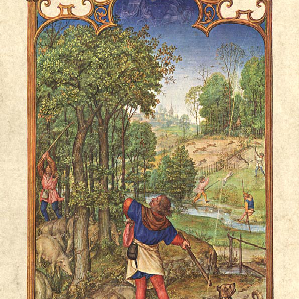

In [7]:
def fetch_image(image_cache, image_url):
    image_name = image_url.rsplit('/', 1)[-1]
    local_name = image_name.rsplit('.', 1)[0] + '.jpg'
    local_path = os.path.join(image_cache, local_name)
    if os.path.isfile(local_path):
        img = Image.open(local_path)
        img.load()
        return center_crop_resize(img, 299)
    image_name = unquote(image_name).replace(' ', '_')
    m = md5()
    m.update(image_name.encode('utf8'))
    c = m.hexdigest()
    for prefix in 'http://upload.wikimedia.org/wikipedia/en', 'http://upload.wikimedia.org/wikipedia/commons':
        url = '/'.join((prefix, c[0], c[0:2], image_name))
        r = requests.get(url)
        if r.status_code != 404:
            try:
                img = Image.open(BytesIO(r.content))
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img.save(local_path)
                return center_crop_resize(img, 299)
            except IOError:
                pass
    return None

fetch_image(IMAGE_DIR, images[0])

In [8]:
valid_images = []
valid_image_names = []
for image_name in tqdm(images):
    img = fetch_image(IMAGE_DIR, image_name)
    if img:
        valid_images.append(img)
        valid_image_names.append(image_name)

  1%|          | 9/1000 [00:18<34:10,  2.07s/it]/home/mitsuhisa.ohta/.pyenv/versions/3.6.0/envs/dlc_org/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
 61%|██████    | 608/1000 [23:13<14:58,  2.29s/it]/home/mitsuhisa.ohta/.pyenv/versions/3.6.0/envs/dlc_org/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
100%|██████████| 1000/1000 [39:04<00:00,  2.34s/it]


In [9]:
len(valid_images)

948

In [10]:
base_model = InceptionV3(weights='imagenet', include_top=True)
base_model.summary()

96116736/96112376 [==============================] - 19s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________

conv2d_48 (Conv2D)              (None, None, None, 1 215040      activation_47[0][0]              
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, None, None, 1 147456      average_pooling2d_4[0][0]        
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, None, None, 1 576         conv2d_40[0][0]                  
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, None, None, 1 576         conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, None, None, 1 576         conv2d_48[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [11]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [24]:
def get_vector(img):
    if not isinstance(img, list):
        images = [img]
    else:
        images = img
    target_size = int(max(images[0].size))
    images = [img.resize((target_size, target_size), Image.ANTIALIAS) for img in images]
    np_imgs = [image.img_to_array(img) for img in images]
    pre_processed = preprocess_input(np.asarray(np_imgs))
    return model.predict(pre_processed)

x = get_vector(valid_images[4])
x.shape

(1, 2048)

In [25]:
chunks = [get_vector(valid_images[i:i+256]) for i in range(0, len(valid_images), 256)]
vectors = np.concatenate(chunks)
vectors.shape

(948, 2048)

In [26]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(vectors)

In [27]:
with open('data/image_similarity.pck', 'wb') as fout:
    pickle.dump({'nbrs': nbrs,
                 'image_names': valid_image_names,
                },
                fout
               )

In [28]:
cat = get_vector(Image.open('data/cat.jpg'))
distances, indices = nbrs.kneighbors(cat)

In [33]:
np_imgs = [image.img_to_array(Image.open('data/cat.jpg'))]
pre_processed = preprocess_input(np.asarray(np_imgs))
x = model.predict(pre_processed)


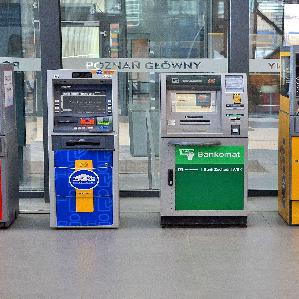
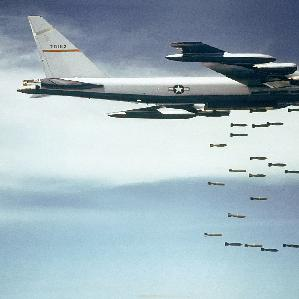
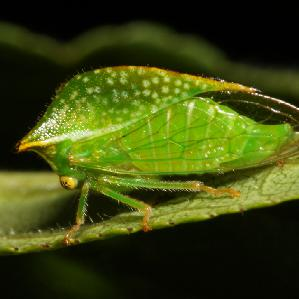
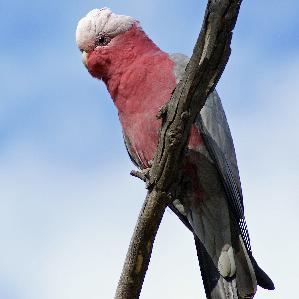
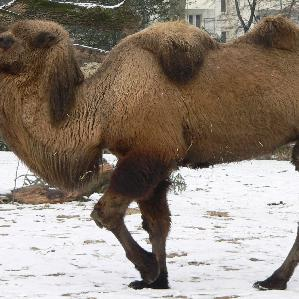
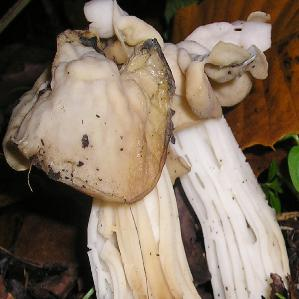
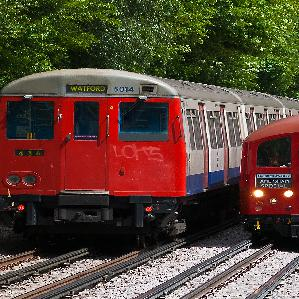
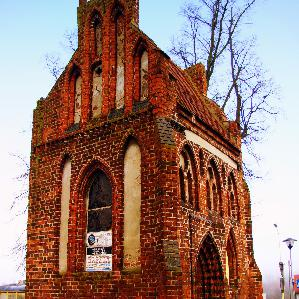
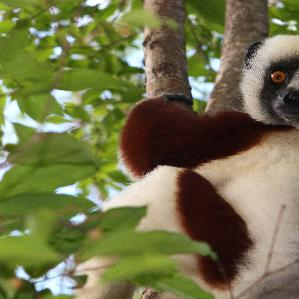
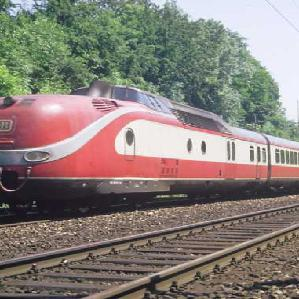

In [34]:
html = []
for idx, dist in zip(indices[0], distances[0]):
    b = BytesIO()
    valid_images[idx].save(b, format='jpeg')
    html.append("<img src='data:image/jpg;base64,{0}'/>".format(base64.b64encode(b.getvalue()).decode('utf-8')))
HTML(''.join(html))



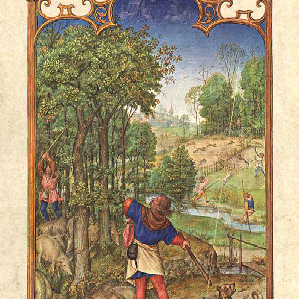

In [35]:
b = BytesIO()
valid_images[0].save(b, format='png')
HTML("<img src='data:image/png;base64,{0}'/>".format(base64.b64encode(b.getvalue()).decode('utf-8')))


In [36]:
nbrs64 = NearestNeighbors(n_neighbors=64, algorithm='ball_tree').fit(vectors)
distances64, indices64 = nbrs64.kneighbors(cat)

In [37]:
vectors64 = np.asarray([vectors[idx] for idx in indices64[0]])

svd = TruncatedSVD(n_components=2)
vectors64_transformed = svd.fit_transform(vectors64)
vectors64_transformed.shape

(64, 2)

In [38]:
img64 = Image.new('RGB', (8 * 75, 8 * 75), (180, 180, 180))

mins = np.min(vectors64_transformed, axis=0)
maxs = np.max(vectors64_transformed, axis=0)
xys = (vectors64_transformed - mins) / (maxs - mins)

for idx, (x, y) in zip(indices64[0], xys):
    x = int(x * 7) * 75
    y = int(y * 7) * 75
    img64.paste(valid_images[idx].resize((75, 75)), (x, y))

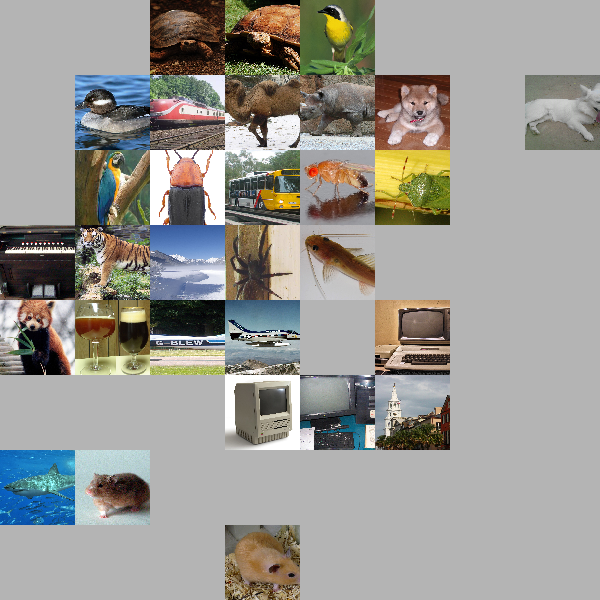

In [39]:
img64

In [40]:
def simple_view(request):
    d = {}
    update_date(request, d)
    if request.FILES.get('painting'):
        data = request.FILES['painting'].read()
        files = {'file': data}
        reply = requests.post('http://localhost:5050', 
                              files=files).json()
        res = reply['results']
        if res:
            d['most_similar'] = res[0]['image_name']

    return render(request, 'template_path/template.html', d)